In [40]:
import os
import sys
from pathlib import Path
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("/Users/matthieuroger/Downloads/Tree-Model-Comparison-Regression")
from ETL.preprocessing import apply_transforms, find_transforms

BASE_DIR: Path = Path(os.getcwd()).resolve().parent


def load_training_data(file_path: Path) -> pd.DataFrame:
    """Load the training dataset from the given file path."""
    return pd.read_csv(file_path)


def prepare_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """Prepare the dataset by separating features and target variable."""
    y: pd.Series = df['SalePrice']
    X: pd.DataFrame = df.drop(columns=['Id', 'SalePrice'])
    return X, y

def load_model(model_name: str):
    """Load a trained model from a pickle file."""
    model_path: Path = BASE_DIR / f"engine/models/{model_name}.pkl"
    
    if os.path.exists(model_path):
        with open(model_path, 'rb') as file:
            return pickle.load(file)
    else:
        raise FileNotFoundError(f"❌ Model {model_name} not found at: {model_path}")



path_data_train: Path = BASE_DIR / 'house_prices/data/train.csv'
df_train: pd.DataFrame = load_training_data(path_data_train)
df_train, y = prepare_data(df_train)

In [36]:
extra_trees_model = load_model("extra_trees")
gradient_boosting_model = load_model("gradient_boosting")

transformation_rules = find_transforms(df_train)
X_encoded = apply_transforms(df_train, transformation_rules)
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [37]:
def predict_mod(model, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    """
    Predict values and display MSE and R² score.
    """
    y_pred = model.predict(X_test)
    
    return y_pred


y_pred_extra= predict_mod(extra_trees_model, X_test_encoded, y_test)
y_pred_grad= predict_mod(gradient_boosting_model, X_test_encoded, y_test)


In [39]:
def evaluate_model(y_test: pd.Series, y_pred: pd.Series, model_name: str) -> None:
    """Evaluate a model using various regression metrics."""
    mse: float = mean_squared_error(y_test, y_pred)
    rmse: float = mse ** 0.5
    mae: float = mean_absolute_error(y_test, y_pred)
    r2: float = r2_score(y_test, y_pred)
    mape: float = (abs((y_test - y_pred) / y_test).mean()) * 100

    print(f"📊 Model Evaluation: {model_name}")
    print(f"✅ MSE  : {mse:.4f}")
    print(f"✅ RMSE : {rmse:.4f}")
    print(f"✅ MAE  : {mae:.4f}")
    print(f"✅ R²   : {r2:.4f}")
    print(f"✅ MAPE : {mape:.2f}%\n")

evaluate_model(y_test, y_pred_extra, "Extra Trees")
evaluate_model(y_test, y_pred_grad, "Gradient Boosting")


📊 Model Evaluation: Extra Trees
✅ MSE  : 1071696326.9162
✅ RMSE : 32736.7733
✅ MAE  : 19341.8443
✅ R²   : 0.8603
✅ MAPE : 11.95%

📊 Model Evaluation: Gradient Boosting
✅ MSE  : 753317059.7890
✅ RMSE : 27446.6220
✅ MAE  : 17468.1081
✅ R²   : 0.9018
✅ MAPE : 11.16%



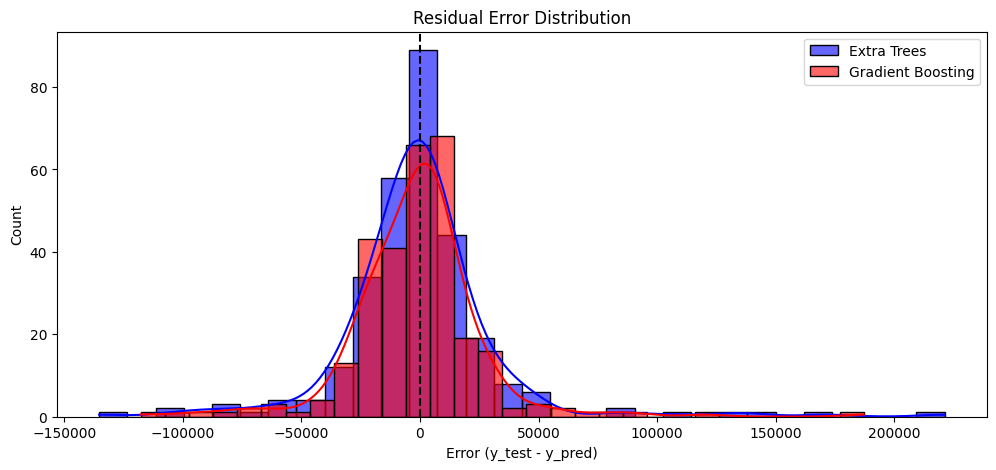

In [41]:
def plot_residual_errors(y_test: pd.Series, y_pred_extra: pd.Series, y_pred_grad: pd.Series) -> None:
    """Plot the distribution of residual errors for both models."""
    errors_extra_trees = y_test - y_pred_extra
    errors_gradient_boosting = y_test - y_pred_grad

    plt.figure(figsize=(12, 5))
    sns.histplot(errors_extra_trees, bins=30, kde=True, color="blue", label="Extra Trees", alpha=0.6)
    sns.histplot(errors_gradient_boosting, bins=30, kde=True, color="red", label="Gradient Boosting", alpha=0.6)
    plt.axvline(0, color="black", linestyle="--")
    plt.legend()
    plt.title("Residual Error Distribution")
    plt.xlabel("Error (y_test - y_pred)")
    plt.show()

plot_residual_errors(y_test, y_pred_extra, y_pred_grad)


The total integral of the error distribution of Extra Trees is larger than that of Gradient Boosting. This is expected since all metrics indicate that the errors of Extra Trees are greater than those of Gradient Boosting. Extra Trees generates more uncommon event errors, as indicated by the distribution tails.


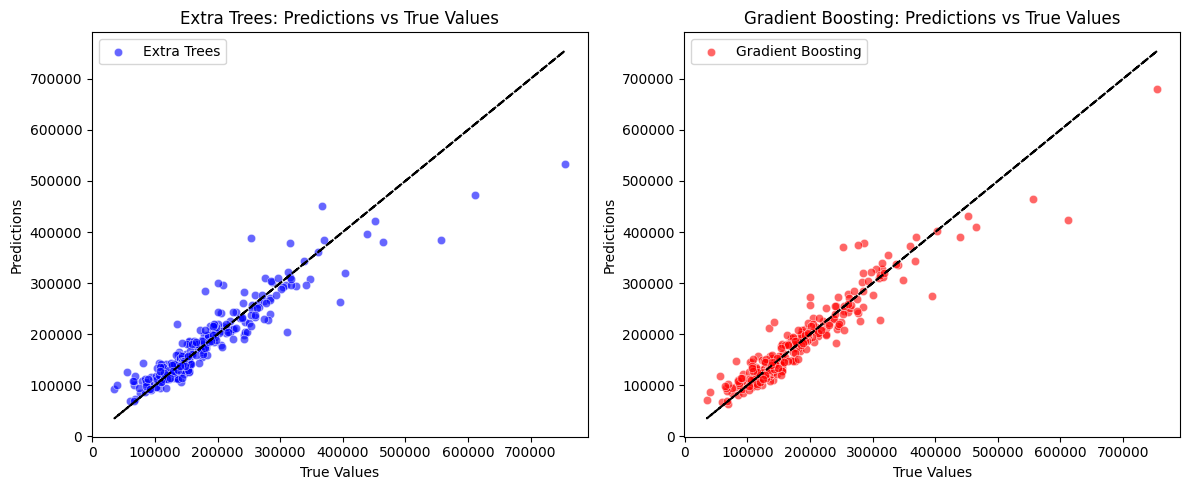

In [42]:
def plot_predictions(y_test: pd.Series, y_pred_extra: pd.Series, y_pred_grad: pd.Series) -> None:
    """Plot predictions versus true values for both models."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test, y=y_pred_extra, alpha=0.6, color="blue", label="Extra Trees")
    plt.plot(y_test, y_test, color="black", linestyle="--")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("Extra Trees: Predictions vs True Values")

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_grad, alpha=0.6, color="red", label="Gradient Boosting")
    plt.plot(y_test, y_test, color="black", linestyle="--")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("Gradient Boosting: Predictions vs True Values")

    plt.tight_layout()
    plt.show()

plot_predictions(y_test, y_pred_extra, y_pred_grad)

The points appear to be slightly farther from the line for Extra Trees compared to Gradient Boosting. Overall, all points follow the diagonal trend. However, we observe that extreme events are not well predicted, as they are rare. 
Both models seem to underestimate expensive houses, likely because the dataset contains fewer high-value properties. This lack of representation makes it difficult for the models to learn patterns for expensive houses, leading to systematic underestimation.
For cheap properties it seems to be the oppsoite, and models overestimates a little.








In [43]:
def worst_predictions(y_test: pd.Series, y_pred: pd.Series, model_name: str, n: int = 10) -> pd.DataFrame:
    """Identify the worst predictions based on the highest squared errors."""
    errors = (y_test - y_pred) ** 2  
    df_errors = pd.DataFrame({"True Value": y_test, "Prediction": y_pred, "Error": errors})
    df_errors = df_errors.sort_values(by="Error", ascending=False).head(n)
    
    print(f"📉 {n} Worst Predictions for {model_name}:")
    print(df_errors)
    return df_errors


def calculate_metrics(df_errors: pd.DataFrame, model_name: str) -> tuple[float, float]:
    """Compute MSE and MAE for the worst predictions."""
    mse = mean_squared_error(df_errors["True Value"], df_errors["Prediction"])
    mae = mean_absolute_error(df_errors["True Value"], df_errors["Prediction"])
    
    print(f"📊 Average Errors of the {len(df_errors)} Worst Predictions for {model_name}:")
    print(f"   🔹 MSE : {mse:.3f}")
    print(f"   🔸 MAE : {mae:.3f}\n")
    
    return mse, mae


worst_extra_trees = worst_predictions(y_test, y_pred_extra, "Extra Trees")
worst_gradient_boosting = worst_predictions(y_test, y_pred_grad, "Gradient Boosting")

mse_extra, mae_extra = calculate_metrics(worst_extra_trees, "Extra Trees")
mse_grad, mae_grad = calculate_metrics(worst_gradient_boosting, "Gradient Boosting")


📉 10 Worst Predictions for Extra Trees:
      True Value  Prediction         Error
691       755000   533770.79  4.894236e+10
1046      556581   384836.36  2.949622e+10
898       611657   472428.92  1.938446e+10
581       253293   388545.66  1.829328e+10
774       395000   263338.21  1.733483e+10
218       311500   203563.40  1.165031e+10
32        179900   284075.63  1.085256e+10
529       200624   300937.09  1.006272e+10
1317      208900   296149.20  7.612423e+09
1243      465000   380644.30  7.115884e+09
📉 10 Worst Predictions for Gradient Boosting:
      True Value     Prediction         Error
898       611657  424561.077040  3.500488e+10
774       395000  274671.958120  1.447884e+10
581       253293  370916.776907  1.383535e+10
261       276000  375062.878688  9.813454e+09
1046      556581  464410.199296  8.495457e+09
1024      287000  378645.733777  8.398941e+09
218       311500  227652.664751  7.030376e+09
588       143000  223171.726890  6.427506e+09
628       135000  211271.48

The MSE and MAE of the 10 worst predictions (based on squared error) are higher for Extra Trees.  


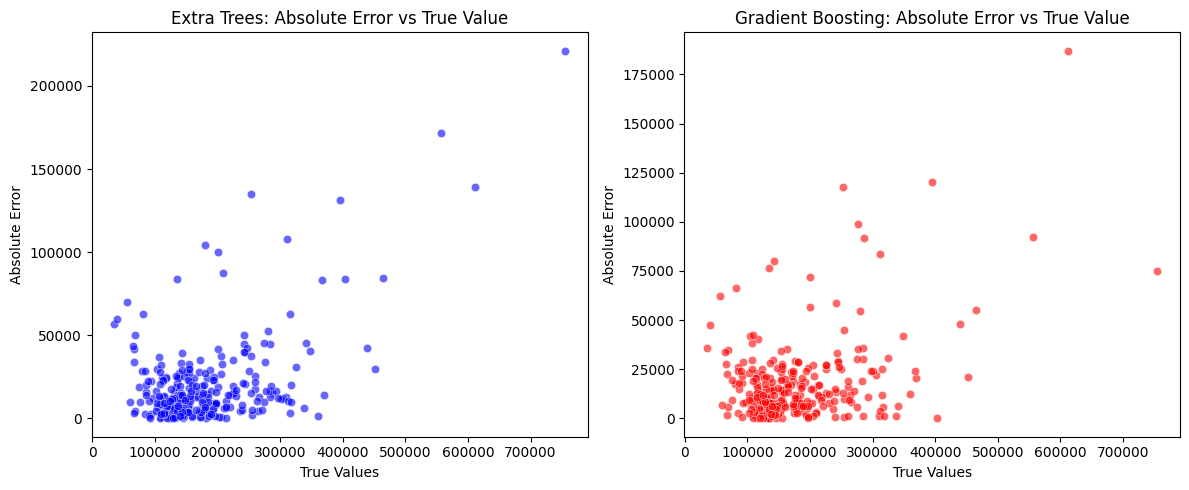

In [44]:
def plot_absolute_errors(y_test: pd.Series, y_pred_extra: pd.Series, y_pred_grad: pd.Series) -> None:
    """Plot absolute errors as a function of true values for both models."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test, y=abs(y_test - y_pred_extra), alpha=0.6, color="blue")
    plt.xlabel("True Values")
    plt.ylabel("Absolute Error")
    plt.title("Extra Trees: Absolute Error vs True Value")

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=abs(y_test - y_pred_grad), alpha=0.6, color="red")
    plt.xlabel("True Values")
    plt.ylabel("Absolute Error")
    plt.title("Gradient Boosting: Absolute Error vs True Value")

    plt.tight_layout()
    plt.show()

plot_absolute_errors(y_test, y_pred_extra, y_pred_grad)

## 🔍 Analysis of Absolute Errors  

### 1. Errors Increase with House Prices  
- The most expensive houses have the largest absolute errors.  
- This suggests that both models struggle to predict high-price houses accurately.  
- A likely reason is the lack of expensive houses in the training dataset.  

### 2. Gradient Boosting Performs Better on Low-Priced Houses  
- The red points are more concentrated at the bottom, indicating that **Gradient Boosting** produces lower errors for cheaper houses.  

### 3. Extra Trees Has More Dispersed Errors  
- Some **extremely high errors** (>200,000) suggest that **Extra Trees** sometimes makes wildly inaccurate predictions.  

## 🔹 Conclusion  
- **Gradient Boosting is more stable**, with generally lower errors.  
- **Extra Trees is less reliable**, occasionally making large mistakes.  
- **Both models struggle with expensive houses**, likely due to a lack of high-value training data.  